# Segmentation Task
In this notebook we will implement Unet architecture for segmentation

Read Data from google drive.

In [ ]:
!unzip '/content/drive/MyDrive/training_DRIVE.zip' 

Archive:  /content/drive/MyDrive/training_DRIVE.zip
   creating: training/
   creating: training/1st_manual/
 extracting: training/1st_manual/21_manual1.gif  
 extracting: training/1st_manual/22_manual1.gif  
 extracting: training/1st_manual/23_manual1.gif  
 extracting: training/1st_manual/24_manual1.gif  
 extracting: training/1st_manual/25_manual1.gif  
 extracting: training/1st_manual/26_manual1.gif  
 extracting: training/1st_manual/27_manual1.gif  
 extracting: training/1st_manual/28_manual1.gif  
 extracting: training/1st_manual/29_manual1.gif  
 extracting: training/1st_manual/30_manual1.gif  
 extracting: training/1st_manual/31_manual1.gif  
 extracting: training/1st_manual/32_manual1.gif  
 extracting: training/1st_manual/33_manual1.gif  
 extracting: training/1st_manual/34_manual1.gif  
 extracting: training/1st_manual/35_manual1.gif  
 extracting: training/1st_manual/36_manual1.gif  
 extracting: training/1st_manual/37_manual1.gif  
 extracting: training/1st_manual/38_manua

In [ ]:
import glob
imgs_dir = glob.glob('/content/training/images/*')
masks_dir = glob.glob('/content/training/1st_manual/*')
imgs_dir.sort()
masks_dir.sort()
print('num of data: ', len(masks_dir))

num of data:  20


show first 5 image and corresponding label directory.

In [ ]:
print(imgs_dir[:5])
print(masks_dir[:5])

['/content/training/images/21_training.tif', '/content/training/images/22_training.tif', '/content/training/images/23_training.tif', '/content/training/images/24_training.tif', '/content/training/images/25_training.tif']
['/content/training/1st_manual/21_manual1.gif', '/content/training/1st_manual/22_manual1.gif', '/content/training/1st_manual/23_manual1.gif', '/content/training/1st_manual/24_manual1.gif', '/content/training/1st_manual/25_manual1.gif']


## Read images and preprocessing

In [ ]:
import cv2
from PIL import Image
import numpy as np

images = []
masks = []
for im, la in zip(imgs_dir, masks_dir):
  img = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
  mask = np.array(Image.open(la))

  images.append(img)
  masks.append(mask)

images = np.array(images)/255.0
masks = np.array(masks)/255.0

print('images shape: ', images.shape)
print('masks shape: ', masks.shape)



images shape:  (20, 584, 565, 3)
masks shape:  (20, 584, 565)


split data to train and validation data

In [ ]:
# train & validation split
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(images, masks, test_size=0.2,random_state =1)

print('train images: ', x_train.shape)
print('train masks: ', y_train.shape)

train images:  (16, 584, 565, 3)
train masks:  (16, 584, 565)


Show a sample image

(-0.5, 564.5, 583.5, -0.5)

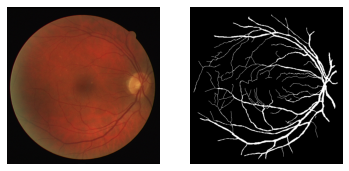

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(x_train[10])
plt.axis('off')
plt.subplot(122)
plt.imshow(y_train[10],cmap='gray')
plt.axis('off')

## extract patches 
a sliding window sweep over the image and extrct image and label patches.

In [ ]:
#%% extract patches
def sliding_window(img, patch_size=[32, 32],
                   istep=8, jstep=8):
    Ni, Nj = (int(s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            yield patch


def patch_extractor(img_mat,mask_mat):
  x_patch = []
  y_patch = []
  for i in range(len(img_mat)):
    x_patch.append(list(sliding_window(img_mat[i])))
    y_patch.append(list(sliding_window(mask_mat[i])))

  x_patch = np.array(x_patch)
  y_patch = np.array(y_patch)

  x_patch = x_patch.reshape([-1,x_patch.shape[2],x_patch.shape[3],x_patch.shape[4]])
  y_patch = y_patch.reshape([-1,y_patch.shape[2],y_patch.shape[3],1])
  return x_patch, y_patch


In [ ]:
x_patch_train, y_patch_train = patch_extractor(x_train,y_train)
x_patch_valid, y_patch_valid = patch_extractor(x_valid,y_valid)

In [ ]:
print('final x train shape: ',x_patch_train.shape)
print('final y train shape: ',y_patch_train.shape)

final x train shape:  (73968, 32, 32, 3)
final y train shape:  (73968, 32, 32, 1)


show a path and its corresponding label

(-0.5, 31.5, 31.5, -0.5)

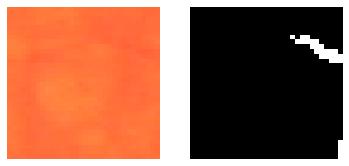

In [ ]:
plt.subplot(121)
plt.imshow(x_patch_train[700])
plt.axis('off')
plt.subplot(122)
plt.imshow(np.squeeze(y_patch_train[700]),cmap='gray')
plt.axis('off')

## **Define Unet**

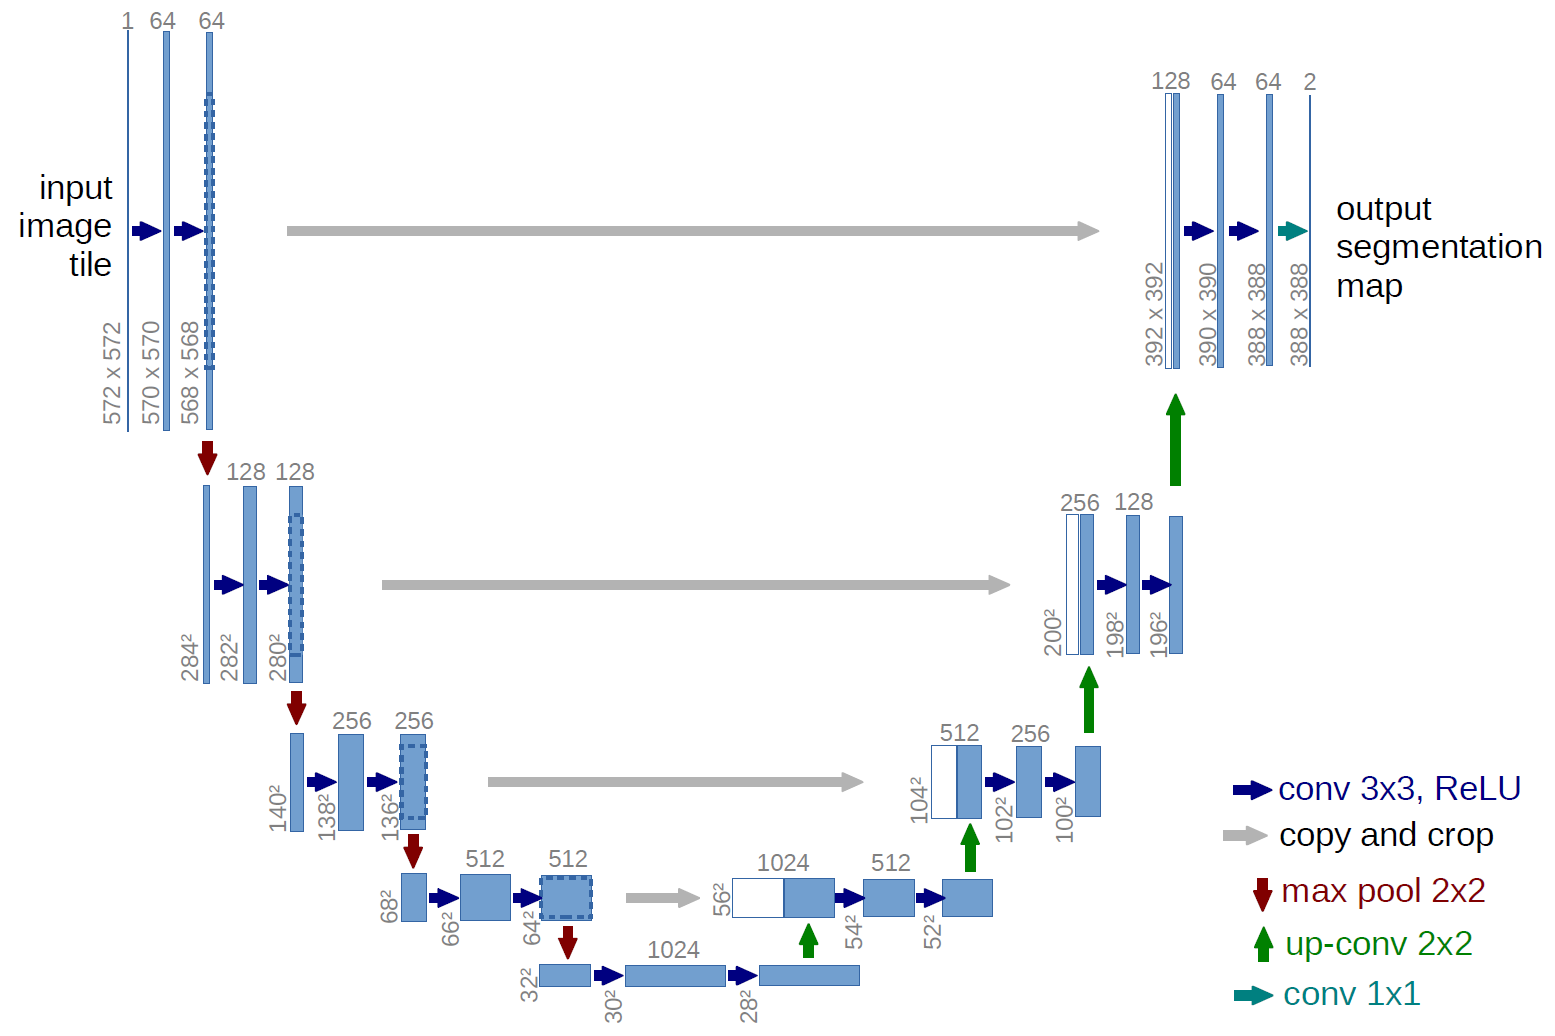

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [ ]:
def conv_layer(x, filter_num = 64, kernel_size = 3):
  x = Conv2D(filters=filter_num, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(filters=filter_num, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

  

In [ ]:
def unet(input_img,filter_num=64, kernel_size = 3):
  # encoder part
  c1 = conv_layer(input_img, filter_num = 1*filter_num, kernel_size = kernel_size)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = conv_layer(p1, filter_num = 2*filter_num, kernel_size = kernel_size)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = conv_layer(p2, filter_num = 4*filter_num, kernel_size = kernel_size)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = conv_layer(p3, filter_num = 8*filter_num, kernel_size = kernel_size)
  p4 = MaxPooling2D((2, 2)) (c4)

  # decoder part
  c5 = conv_layer(p4, filter_num = 16*filter_num, kernel_size = kernel_size)

  u6 = Conv2DTranspose(8*filter_num, (kernel_size, kernel_size), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = conv_layer(u6, filter_num = 8*filter_num, kernel_size = kernel_size)

  u7 = Conv2DTranspose(4*filter_num, (kernel_size, kernel_size), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = conv_layer(u7, filter_num = 4*filter_num, kernel_size = kernel_size)

  u8 = Conv2DTranspose(2*filter_num, (kernel_size, kernel_size), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = conv_layer(u8, filter_num = 2*filter_num, kernel_size = kernel_size)

  u9 = Conv2DTranspose(1*filter_num, (kernel_size, kernel_size), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  c9 = conv_layer(u9, filter_num = 1*filter_num, kernel_size = kernel_size)

  out = Conv2D(1, (1, 1), activation='sigmoid') (c9)
  model = Model(inputs=[input_img], outputs=[out])
  return model



In [ ]:
input_img = Input((32, 32, 3), name='img')
unet_model = unet(input_img)

In [ ]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 64)   1792        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 32, 32, 64)   256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 32, 32, 64)   0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [ ]:
unet_model.compile(optimizer='adam', loss = 'binary_crossentropy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = unet_model.fit(x_patch_train,y_patch_train, epochs=20, batch_size=4, 
                         validation_data=(x_patch_valid,y_patch_valid), callbacks = callbacks)

Epoch 1/20
18492/18492 [==============================] - 472s 25ms/step - loss: 0.1093 - val_loss: 0.1039

Epoch 00001: val_loss improved from inf to 0.10387, saving model to model-segmentation.h5
Epoch 2/20
18492/18492 [==============================] - 470s 25ms/step - loss: 0.0883 - val_loss: 0.1108

Epoch 00002: val_loss did not improve from 0.10387
Epoch 3/20
18492/18492 [==============================] - 455s 25ms/step - loss: 0.0776 - val_loss: 0.1208

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_loss did not improve from 0.10387
Epoch 4/20
18492/18492 [==============================] - 454s 25ms/step - loss: 0.0639 - val_loss: 0.1148

Epoch 00004: val_loss did not improve from 0.10387
Epoch 00004: early stopping


In [ ]:
# saving the model in tensorflow format
unet_model.save('/content/drive/MyDrive/deep_tutorial/drive_unet',save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/deep_tutorial/drive_unet/assets


In [ ]:
unet_model = tf.keras.models.load_model('/content/drive/MyDrive/deep_tutorial/drive_unet')

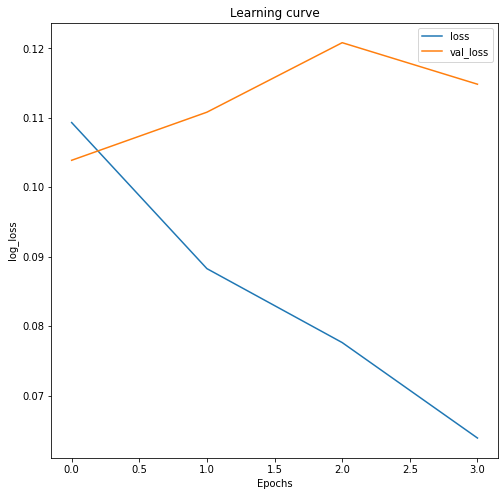

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## use model to predict

In [ ]:
predicted_outs = []
for numm in range(4):
  final_mask = np.zeros([584,565])
  x_test = x_valid[numm]
  for i in range(0, 584-32, 32):
    for j in range(0, 565-32, 32):
      patch_ext = tf.expand_dims(x_test[i:i+32, j:j+32,:], axis = 0)
      predicted = np.squeeze(unet_model.predict(patch_ext))

      out_pre = np.zeros([32,32])
      out_pre[np.where(predicted>=0.5)] = 1
      final_mask[i:i+32, j:j+32] = out_pre

  predicted_outs.append(final_mask)
predicted_outs = np.array(predicted_outs)



(-0.5, 564.5, 583.5, -0.5)

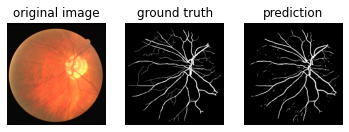

In [ ]:
numm = 3
plt.subplot(131)
plt.imshow(x_valid[numm])
plt.title('original image')
plt.axis('off')
plt.subplot(132)
plt.imshow(y_valid[numm], cmap='gray')
plt.title('ground truth')
plt.axis('off')
plt.subplot(133)
plt.imshow(predicted_outs[numm], cmap='gray')
plt.title('prediction')
plt.axis('off')

## dice score for segmentation assessment

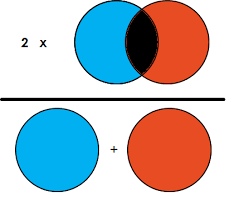

In [ ]:
import numpy as np
def dice_coef(y_true, y_pred):
    '''
    Params: y_true -- the labeled mask corresponding to an rgb image
            y_pred -- the predicted mask of an rgb image
    Returns: dice_coeff -- A metric that accounts for precision and recall
                           on the scale from 0 - 1. The closer to 1, the
                           better.
    Citation (MIT License): https://github.com/jocicmarko/
                            ultrasound-nerve-segmentation/blob/
                            master/train.py
    '''
    y_true_f = np.ndarray.flatten(y_true)
    y_pred_f = np.ndarray.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 1.0
    return (2.0*intersection+smooth)/(np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

In [ ]:
dice_coef(y_valid, predicted_outs)

0.7996225011366298

# Contact me!!
If you have questions, please feel free to ask. \\
`RezaKarimzadeh1996@gmail.com`